In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# cats vs dogs kaggle competition dataset 
now we're going to start to building our Convolutional Neural Network, but first we need the data so we are going to work with the cats vs dogs dataset. from the kaggle competition. by using this command **kaggle competitions download -c dogs-vs-cats** 
but make sure you have kaggle installed **pip install kaggle**
and you have the kaggle api installed and you have the kaggle.json file in your home directory.
1. Go to your Kaggle account settings.
2. Under the "API" section, click "Create New API Token". This action will download a kaggle.json file to your computer.
3. Move the downloaded kaggle.json file to C:\Users\dell\.kaggle.


In [5]:
import os, glob, random, shutil

base_dir     = 'data'
split_ratios = {'train': 0.80, 'valid': 0.10, 'test': 0.10}
classes      = ['cat', 'dog']

random.seed(42)

# Make sure your split directories exist
for split in split_ratios:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Do the split for each class
for cls in classes:
    # Find all images like 'cat.0.jpg', 'dog.0.jpg' in data/train/
    all_files = glob.glob(os.path.join(base_dir, 'train', f'{cls}.*.jpg'))
    random.shuffle(all_files)
    n_total = len(all_files)
    n_train = int(n_total * split_ratios['train'])
    n_valid = int(n_total * split_ratios['valid'])
    n_test  = n_total - n_train - n_valid

    train_files = all_files[:n_train]
    valid_files = all_files[n_train:n_train + n_valid]
    test_files  = all_files[n_train + n_valid:]

    def mover(file_list, split_name):
        dest = os.path.join(base_dir, split_name, cls)
        for filepath in file_list:
            shutil.move(filepath, dest)

    mover(train_files, 'train')
    mover(valid_files, 'valid')
    mover(test_files,  'test')

In [6]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

we are going to transform the data into an acceptable format for the sequential model, using ImageDataGenerator class.

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=64)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=64)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=64, shuffle=False)


Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [8]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-112.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..140.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data

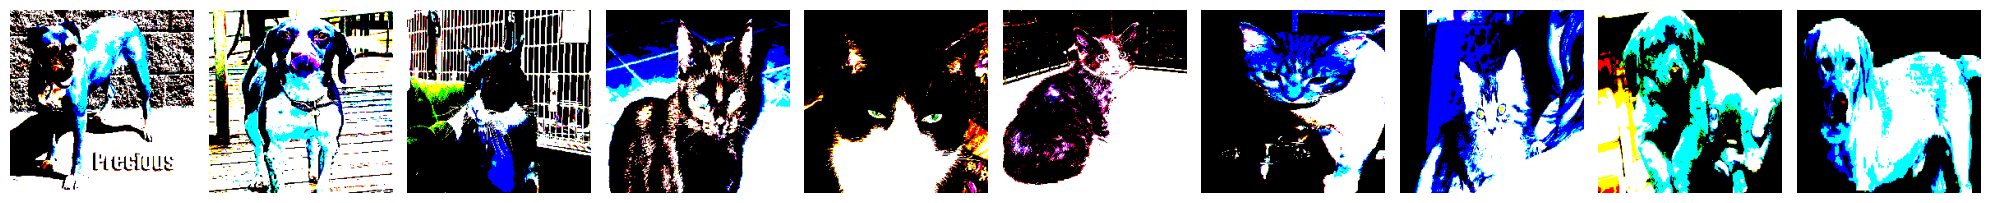

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(labels)